# LSTM 모델링 (2020년 6월 예측용)

In [1]:
import pandas as pd
from datetime import datetime

perform_df = pd.read_json('datas/raw_data/raw_perform.json')
rating_df = pd.read_json('datas/raw_data/raw_rating.json')

# Datetime으로 변환
perform_df['방송일시'] = list(map(lambda i : datetime.fromtimestamp(i/1000), perform_df['방송일시']))
perform_df['날짜'] = list(map(lambda i : i.date(), perform_df['방송일시']))

# 취급액 int형식으로 변경
perform_df[' 취급액 '] = list(map(lambda i : int(i.replace(',','')) if i != None else None, perform_df[' 취급액 ']))

In [11]:
pip install keras

Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the 'C:\Users\svsta\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
ts = perform_df.groupby('날짜').sum()

In [4]:
ts = ts[' 취급액 ']

In [5]:
import time
ts['날짜'] = list(map(lambda i: time.mktime(i.timetuple()), ts['날짜']))

KeyError: '날짜'

In [8]:
df = ts.reset_index()

In [9]:
df = df[['날짜', ' 취급액 ']]

In [11]:
# import statsmodels.api as sm
# data = sm.datasets.get_rdataset("deaths", "MASS")
# df = data.data
# df.tail()

import numpy as np
# 타임스텝
ts = 7

df[" 취급액 "] = df[' 취급액 '].map(lambda x : (x - df[' 취급액 '].mean()) / np.std(df[' 취급액 ']))
X_train = np.asarray([np.array([df[' 취급액 '].values[i+j] for j in range(ts)])
                      for i in range(len(df[' 취급액 ']) - ts)]).reshape(-1,ts,1)
y_train = df[' 취급액 '].values[ts:]
X_train.shape, y_train.shape

((359, 7, 1), (359,))

In [12]:
ts

7

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(ts, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
import matplotlib.pyplot as plt

findfont: Font family ['BMJUA_ttf'] not found. Falling back to DejaVu Sans.


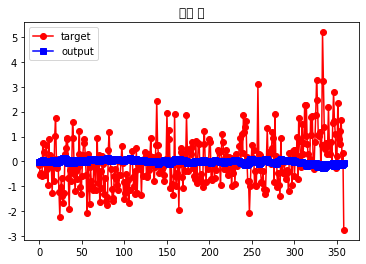

In [55]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("학습 전")
plt.show()

In [14]:
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000,verbose=0)

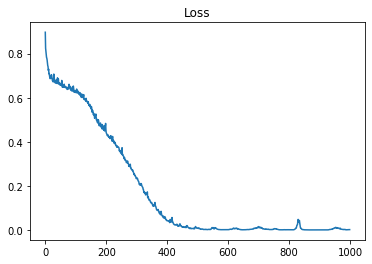

In [18]:
plt.plot(history_LSTM.history["loss"])
plt.title("Loss")
plt.show()

findfont: Font family ['BMJUA_ttf'] not found. Falling back to DejaVu Sans.
findfont: Font family ['BMJUA_ttf'] not found. Falling back to DejaVu Sans.


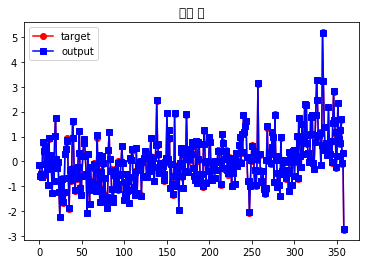

In [17]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("학습 후")
plt.show()

In [24]:
X_train.shape

(359, 7, 1)

In [23]:
y_train.shape

(359,)

# 향후 180일 연속 예측

In [28]:
X_train = np.asarray([np.array([y_train[i+j] for j in range(ts)])
                      for i in range(len(y_train) - ts)]).reshape(-1,ts,1)

In [36]:
y_values = model_LSTM.predict(X_train)[-7:]

In [37]:
y_values

array([[ 0.9005662 ],
       [ 0.72207165],
       [ 1.2428486 ],
       [ 1.7068622 ],
       [-0.06560108],
       [ 0.35596168],
       [-2.7005348 ]], dtype=float32)

In [33]:
next_7day = np.asarray([np.array([y_values[i+j] for j in range(ts)])
                      for i in range(len(y_values) - ts)]).reshape(-1,ts,1)

array([[ 0.9005662 ],
       [ 0.72207165],
       [ 1.2428486 ],
       [ 1.7068622 ],
       [-0.06560108],
       [ 0.35596168],
       [-2.7005348 ],
       [-2.355083  ]], dtype=float32)

In [ ]:
y_values = model_LSTM.predict(X_train)[-7:]
new_value = model_LSTM.predict(y_values.reshape(-1,ts,1))


In [56]:
new_datas = []
for i in range(180):
    if i == 0:
        new_values = np.vstack((y_values,new_value))[-7:]
    else:
        new_values = np.vstack((new_values,new_value))[-7:]
    new_value = model_LSTM.predict(new_values.reshape(-1,ts,1))
    new_datas.append(new_value)

In [63]:
import itertools
final = list(itertools.chain(*new_datas))

In [65]:
final = list(itertools.chain(*final))

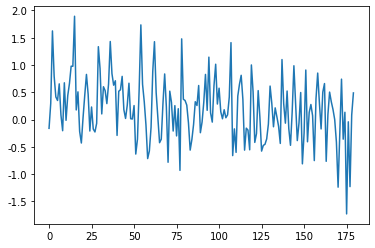

In [67]:
plt.plot(final)